In [109]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)



Toggle code

# Plot regional maps with mean current ellipses on top


In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import iris
import iris.plot as iplt
import iris.quickplot as qplt

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import palettable
from palettable import colorbrewer
from palettable.cmocean.sequential import Ice_12 as ocean

#plt.rcParams.update({'font.size': 14})

## 1. Load data

### Load location of EEL stations

In [111]:
pathdir = '../data/raw'

file3 = pathdir+'/'+'EELCTDandLADCP_refpos_origCTD.csv'
dfloc = pd.read_csv(file3,sep=',', index_col=None, 
                     header=0)
# Make sure the station name are sorted by their distance along the section
sdfloc = dfloc.sort_values('CDist', ascending=True)
print(sdfloc)

   Staname        CDist  LonSta  LatSta  DepthSta
68   IB23S     0.000000 -20.215  63.317       120
67   IB22S    13.442044 -20.067  63.216       670
66   IB21S    25.375111 -19.916  63.133      1030
65   IB20S    55.616831 -19.551  62.917      1400
64   IB19S    84.025700 -19.668  62.667      1670
..     ...          ...     ...     ...       ...
4       5G  1277.489387  -6.600  56.733        80
3       4G  1286.632474  -6.450  56.733       115
2       3G  1292.405649  -6.367  56.708        70
1       2G  1298.235343  -6.283  56.683        30
0       1G  1307.563533  -6.133  56.667       190

[69 rows x 5 columns]


<br><br>
## 2. Plot maps of bathymetrie


#### Plot a topography map using the etopo1 data from the NOAA opendap server. With iris we can slice the data before downloading it. Finally we will "print" our cube to check the metadata.

In [112]:
# Definition variables for maps
central_lon, central_lat = -10, 45
extent_extract = [-30, 10, 50, 70]
extent_map = [-26, 0, 51, 66]

In [113]:
def get_cube(url):
    coord_values = {'latitude':lambda cell: extent_extract[2] <= cell <= extent_extract[3],
                    'longitude': lambda cell: extent_extract[0] <= cell <= extent_extract[1]}
    constraint = iris.Constraint(coord_values=coord_values)
    bathy = iris.load_cube(url, constraint)
    return bathy

# try:
#     bathy = get_cube('/Users/locupe/Dropbox/Work/function_MATLAB/bathymetrie/bathy_gebco.nc')
# except:
#     bathy = get_cube('http://thredds.aoos.org/thredds/dodsC/GEBCO2014_NORTHERN_HEM.nc')

bathy = get_cube('http://thredds.aoos.org/thredds/dodsC/GEBCO2014_NORTHERN_HEM.nc') 
bathy = iris.util.squeeze(bathy)



print(bathy)

/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:324: UserWarning: Missing CF-netCDF auxiliary coordinate variable 'y', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name))
/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:324: UserWarning: Missing CF-netCDF auxiliary coordinate variable 'x', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name))
/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:649: UserWarning: Missing CF-netCDF label variable 'y', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name))
/Users/locupe/anaconda2/envs/analysis_eel_data/lib/python3.8/site-packages/iris/fileformats/cf.py:649: UserWarning: Missing CF-netCDF label variable 'x', referenced by netCDF variable 'elevation'
  warnings.warn(message % (name, nc_var_name)

height_above_reference_ellipsoid / (m) (latitude: 2400; longitude: 4800)
     Dimension coordinates:
          latitude                              x                -
          longitude                             -                x
     Scalar coordinates:
          time: 2014-12-03 00:00:00
     Attributes:
          Conventions: CF-1.0
          History: Translated to CF-1.0 Conventions by Netcdf-Java CDM (NetcdfCFWriter)
Original...
          NCO: 4.4.8
          comment: The data in the GEBCO_2014 Grid should not be used for navigation or any...
          history: Tue May  5 08:08:12 2015: ncpdq -O -a lat,lon GEBCO_2014_2D_-180.0_0.0_180.0_90.0_lon.nc...
          institution: On behalf of the General Bathymetric Chart of the Oceans (GEBCO), the data...
          nco_openmp_thread_number: 1
          node_offset: 1
          references: Information on the data set is available from the GEBCO project web pages:...
          sdn_parameter_name: Sea floor height (above mean sea lev

<br><br>
### Define Plotting function

\
Define specific function to plot map

In [114]:
# Define a function to plot the background map
def plot_bathy_ENA(fig=False,ax=False,limits='default',gridlines=True,colorbar=True):
    """ Function to plot the map of the Eastern North Atlantic with the associated bathymetry

    plot_bathy_ENA(fig=False,ax=False,limits='default',gridlines=True,colorbar=True)
    
    Returns:
    (fig, ax, cplot): Figure, axes and contourf objects generated by plt.subplots

    """
    
    land = colorbrewer.get_map('Accent', 'qualitative', 8)
    #ocean = colorbrewer.get_map('Blues', 'sequential', 6, reverse=True)
    colors = np.array(ocean.mpl_colors[-6:])

    levels = [-3000, -2000, -1250, -1000, -650, -200, 0]

    #titlefig = 'Map Eastern North Atlantic'
    if not fig:
        fig, ax = plt.subplots(figsize=(12, 12),
                               subplot_kw=dict(projection=ccrs.Mercator(central_lon, central_lat)))
    else:
        plt.axes(ax)
    
    cplot = iris.plot.contourf(bathy, levels, colors=colors, extend='both')
    cplot.cmap.set_under(ocean.mpl_colors[-7])
    cplot.cmap.set_over(land.mpl_colors[-1])

    # Set the colormap limits
    plt.clim([np.min(levels),np.max(levels)])
    
    if colorbar:
        cbar = plt.colorbar(cplot, ax=ax, orientation="vertical", pad=.05, aspect=40)  
        cbar.ax.set_ylabel('Depth (m)')
        
    if limits=='default':
        ax.set_extent([-28.1, 0.1, 51, 66])
    else:
        ax.set_extent(limits)       
        
    ax.coastlines('10m', color='k')

    if (limits=='default') & gridlines:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), ylocs=np.arange(52,68,2),
                          draw_labels=True, linewidth=1, color='gray', alpha=0.8, linestyle='-.')

        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
    
    return (fig, ax, cplot)

\
Define specific function to plot specific gridlines on a map

In [115]:
# Define a function to plot grid axis on map
def plot_gridlines(ax,xtick,ytick):
    """ Function to plot gridline on a map generated by cartopy (on a PlateCarree projection)

    plot_gridlines(ax,xtick,ytick)
    
    Returns:
    gl: gridline object

    """
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, 
                       linewidth=1, color='gray', alpha=0.8, linestyle='-.')
    gl.ylocator = mticker.FixedLocator(ytick)
    gl.xlocator = mticker.FixedLocator(xtick)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
 
    
    return gl

In [116]:
plot_bathy_ENA?

Signature:
plot_bathy_ENA(
    fig=False,
    ax=False,
    limits='default',
    gridlines=True,
    colorbar=True,
)
Docstring:
Function to plot the map of the Eastern North Atlantic with the associated bathymetry

plot_bathy_ENA(fig=False,ax=False,limits='default',gridlines=True,colorbar=True)

Returns:
(fig, ax, cplot): Figure, axes and contourf objects generated by plt.subplots
File:      ~/Dropbox/Work/Python/Repos_perso/analysis_eel_data/notebooks/<ipython-input-114-a02d7c94c44a>
Type:      function


\
Test 

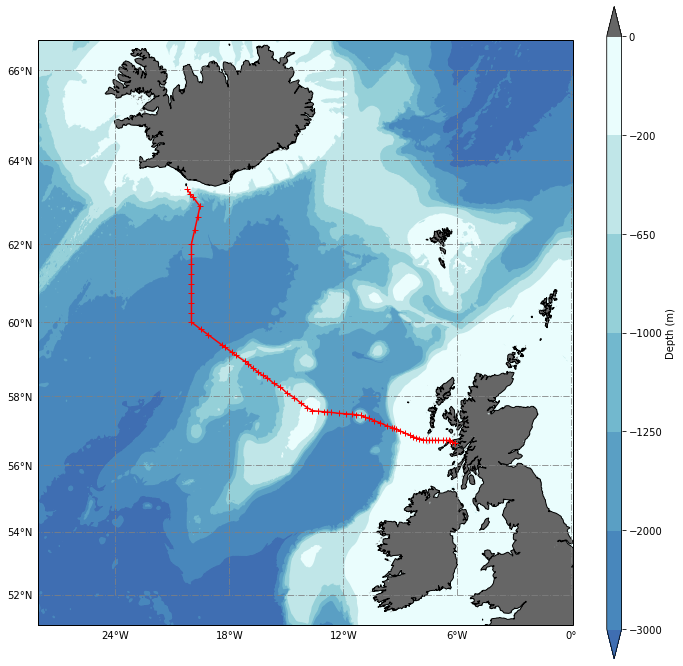

In [117]:
# plot map with EEL stations
(fig,ax,cplot)=plot_bathy_ENA()    

ax.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree())

<br><br>
#### Plot regional zoom 

Plot Map for Rockall Trough area

Text(0.5, 0, 'Depth (m)')

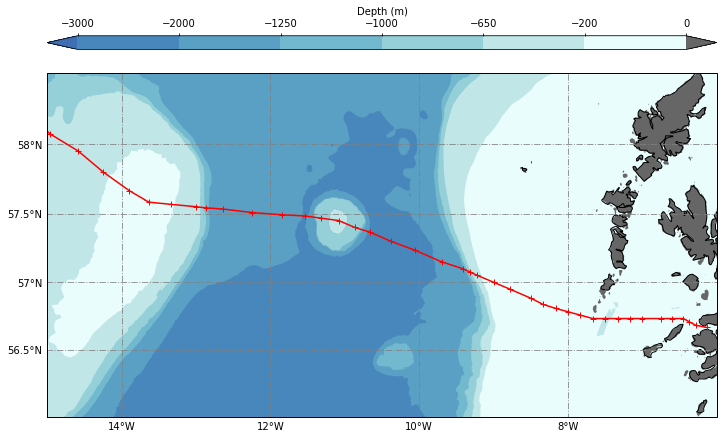

In [119]:
(fig,axRT,cplot)=plot_bathy_ENA(limits=[-15, -6, 56, 58.5],colorbar=False)
plot_gridlines(axRT,np.arange(-20,-2,2),np.arange(55.5,59.5,0.5));

#----------------------------
# EEL stations
axRT.plot(sdfloc['LonSta'], sdfloc['LatSta'],
         color='red', linestyle='-', marker='+', transform=ccrs.PlateCarree());

#----------------------------
# Colorbar

# Add an axes above the main axes.
axRT_divider = make_axes_locatable(axRT)
# Need to import matplotlib's axes class due to the projection used to generate ax2 and ax1
import matplotlib.axes as maxes

caxRT = axRT_divider.append_axes("top", size="4%", pad="7%", axes_class=maxes.Axes)
cb2 = fig.colorbar(cplot, cax=caxRT, orientation="horizontal")
# change tick position to top
caxRT.xaxis.set_ticks_position("top")
caxRT.xaxis.set_label_position("top")
caxRT.set_xlabel('Depth (m)')

## TODO2: Produce other version of the figure with mean current ellipses at different depths (eg 100m, 800m, 2500m), perhaps with some representation of data coverage (eg dot size to indicate number of occupations of each station)